In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import glob
from itertools import product

from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import PIL
from scipy.ndimage import imread
from scipy.misc import imresize
from scipy.stats import zscore

%matplotlib inline

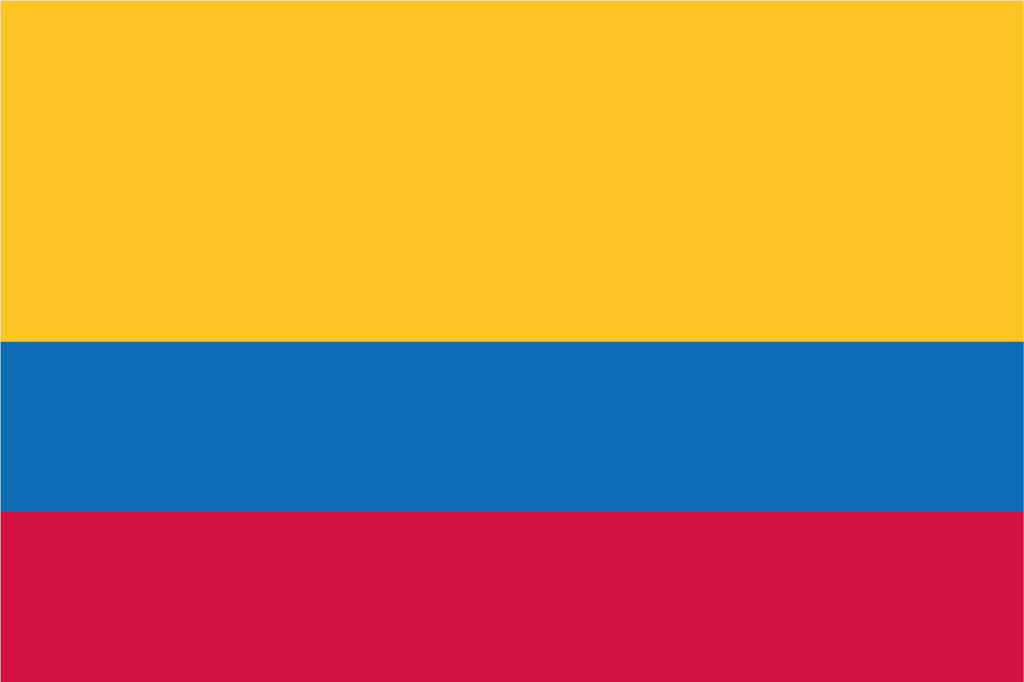

In [3]:
# testing

## to display an image from disk
from IPython.display import Image 

Image('flags/colombia.jpg')

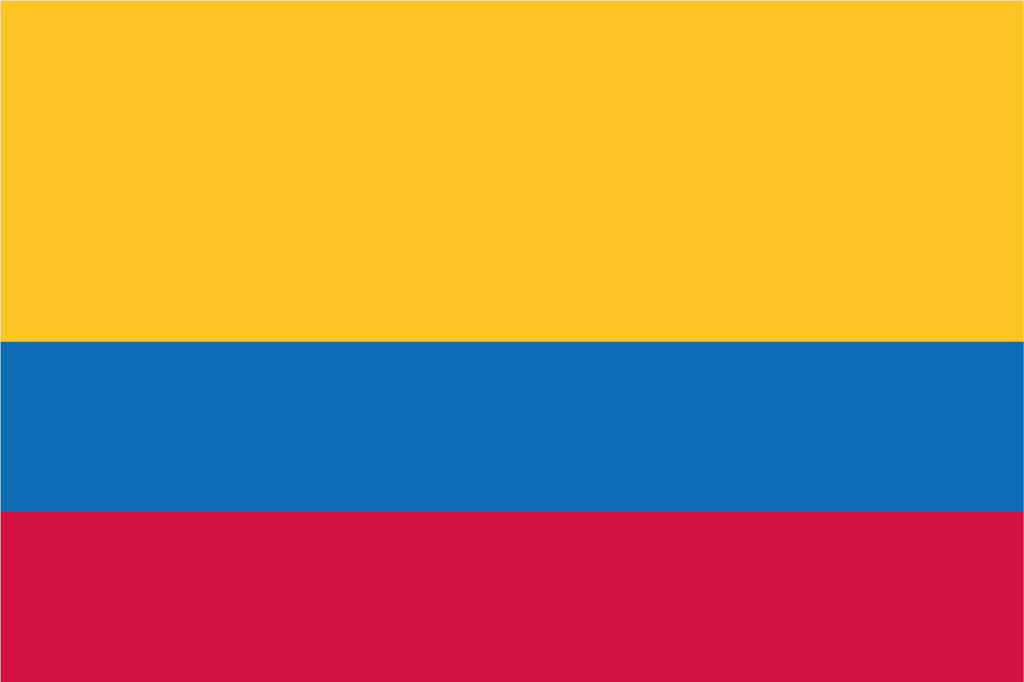

In [4]:
## to display an array as an image
colombia_bitmap = imread('flags/colombia.jpg')
PIL.Image.fromarray(colombia_bitmap)

# Import flag bitmaps as numpy arrays

In [99]:
def extract_country_slug(file):
    return file.split('/')[-1].split('.')[0]

In [100]:
flag_bitmaps = []
countries = []

for file in glob.glob('flags/*.jpg'):
    flag_bitmaps.append( imread(file) )
    countries.append( extract_country_slug(file) )

# Normalize data

## Resize all flags to the proportions of the largest bounding box

In [6]:
flag_bitmap_shapes = [bitmap.shape for bitmap in flag_bitmaps]

max_first_dimension = max([shape[0] for shape in flag_bitmap_shapes])
max_second_dimension = max([shape[1] for shape in flag_bitmap_shapes])
max_third_dimension = max([shape[2] for shape in flag_bitmap_shapes])

max_bounding_box = (max_first_dimension, max_second_dimension, max_third_dimension)
print('Max bounding box: ({}, {}, {})'.format(*max_bounding_box))

Max bounding box: (684, 1025, 3)


In [7]:
reduced_max_bounding_box = (68, 102, 3)
print('Reduced size bounding box ({}, {}, {})'.format(*reduced_max_bounding_box))

Reduced size bounding box (68, 102, 3)


In [8]:
resized_flag_bitmaps = [imresize(bitmap, size=reduced_max_bounding_box) for bitmap in flag_bitmaps]

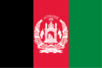

In [9]:
PIL.Image.fromarray(resized_flag_bitmaps[0])

## Scale images to [0, 1], flatten images, then create an input matrix

In [10]:
input_matrix = np.array([bitmap.flatten() / 255. for bitmap in resized_flag_bitmaps])

# Instantiate network

In [11]:
from vanilla_neural_nets.autoencoder.sparse_autoencoder.network import VanillaSparseAutoencoder
from vanilla_neural_nets.neural_network.training_batch_generator import MiniBatchGenerator
from vanilla_neural_nets.autoencoder.sparse_autoencoder.optimization_algorithm import SparsityEnforcingGradientDescent
from vanilla_neural_nets.autoencoder.sparse_autoencoder.loss_function import SparseMeanSquaredError, KLDivergenceSparsityLoss
from vanilla_neural_nets.neural_network.activation_function import SigmoidActivationFunction
from vanilla_neural_nets.neural_network.parameter_initialization import GaussianWeightInitializer, GaussianBiasInitializer

In [12]:
N_HIDDEN_UNITS = 64
N_SAMPLES = input_matrix.shape[0]
N_FEATURES = input_matrix.shape[1]
LAYER_SIZES = [N_FEATURES, N_HIDDEN_UNITS, N_FEATURES]

In [77]:
LEARNING_RATE = .05
TRAINING_BATCH_SIZE = 72
N_EPOCHS = 200
RANDOM_STATE = 123
RHO = .05
BETA = .25
GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION = 1. / np.sqrt(N_FEATURES)

In [78]:
training_set = input_matrix[:100, :]
validation_set = input_matrix[100:120, :]
test_set = input_matrix[120:, :]

In [79]:
class VanillaSparseAutoencoderWithLogging(VanillaSparseAutoencoder):
    
    def fit(self, X, y):
        for epoch in range(self.n_epochs):
            training_batch_generator = self.training_batch_generator_class(X=X, y=y, batch_size=self.training_batch_size,
                random_number_generator=self.random_number_generator)

            for training_batch in training_batch_generator:
                self.parameters = self._update_network_layers_with_training_batch(training_batch)
                
            if epoch % 25 == 0:
                print('Epoch: {}'.format(epoch))
                print('Training Loss: {}'.format( self._compute_loss(X=X, y=y)) )
                print('Validation Loss: {}'.format( self._compute_loss(X=validation_set, y=validation_set)) )
                print('Test Loss: {}'.format( self._compute_loss(X=test_set, y=test_set)) )
            
    def _compute_loss(self, X, y):
        predictions, mean_hidden_layer_activations = self.predict(X)
        loss = self.loss_function_class.loss(
            y_true=y,
            y_predicted=predictions,
            rho=RHO,
            vector_of_rho_hats=mean_hidden_layer_activations,
            beta=BETA
        )
        if np.isinf(loss).sum() > 0:
            from IPython.core.debugger import Tracer; Tracer()()
        return loss

In [80]:
network = VanillaSparseAutoencoderWithLogging(
    layer_sizes=LAYER_SIZES,
    training_batch_generator_class=MiniBatchGenerator,
    loss_function_class=SparseMeanSquaredError,
    activation_function_class=SigmoidActivationFunction,
    optimization_algorithm_class=SparsityEnforcingGradientDescent,
    sparsity_constraint_class=KLDivergenceSparsityLoss,
    learning_rate=LEARNING_RATE,
    n_epochs=N_EPOCHS,
    training_batch_size=TRAINING_BATCH_SIZE,
    random_state=RANDOM_STATE,
    rho=RHO,
    beta=BETA,
    weight_initializer=GaussianWeightInitializer(
        GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION,
        random_state=RANDOM_STATE
    ),
    bias_initializer=GaussianBiasInitializer(
        GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION,
        random_state=RANDOM_STATE
    )
)

# Train

In [81]:
network.fit(X=training_set, y=training_set)

Epoch: 0
Training Loss: 1486.3847668880712
Validation Loss: 1485.1386814293521
Test Loss: 1472.3265468095983
Epoch: 25
Training Loss: 1249.2448622674483
Validation Loss: 1341.0245739334825
Test Loss: 1279.0018358725622
Epoch: 50
Training Loss: 1057.1191530844544
Validation Loss: 1232.86206466118
Test Loss: 1155.2801089214252
Epoch: 75
Training Loss: 967.057231628783
Validation Loss: 1176.9478495655026
Test Loss: 1110.016263958894
Epoch: 100
Training Loss: 897.3655751542308
Validation Loss: 1132.988438549415
Test Loss: 1073.2778093443571
Epoch: 125
Training Loss: 831.3963941274901
Validation Loss: 1084.491284423306
Test Loss: 1038.3474706756247
Epoch: 150
Training Loss: 783.1074703478839
Validation Loss: 1061.1282181131617
Test Loss: 1010.6965274084168
Epoch: 175
Training Loss: 734.6826253184481
Validation Loss: 1027.6479892677903
Test Loss: 985.1755355132254


# Visualize features

In [82]:
def reshape_for_visualization(image_vector):
    return (image_vector.reshape(*reduced_max_bounding_box) * 255).astype(np.uint8)

In [83]:
def visualize_image(image_vector):
    return PIL.Image.fromarray(image_vector)

In [84]:
maximally_activating_inputs = []

for row in network.parameters.weight_parameters[0].value:
    norm_bounded_input = row / np.linalg.norm(row)
    maximally_activating_inputs.append( reshape_for_visualization(norm_bounded_input) )

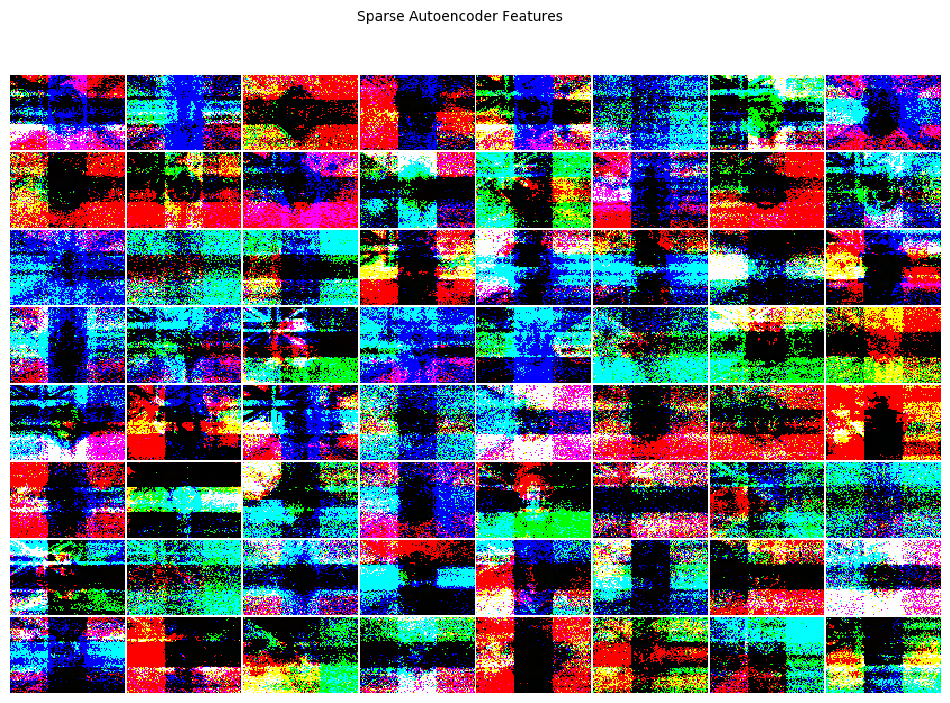

In [85]:
n_rows = n_cols = 8

plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=.025, hspace=0)

for i, (r, c) in enumerate(product(range(n_rows), range(n_cols))):
    ax = plt.subplot(gs[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.imshow(maximally_activating_inputs[i], cmap='gray', interpolation='nearest')

plt.suptitle('Sparse Autoencoder Features')

# How well can the autoencoder recreate an image?

In [86]:
afghanistan_input = input_matrix[0]
afghanistan_reduced_bitmap = reshape_for_visualization(afghanistan_input)

## Original, reduced-size Afghanistan flag

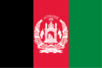

In [87]:
visualize_image(afghanistan_reduced_bitmap)

## Reduced-sized Afghanistan flag reconstructed by our network

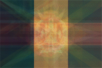

In [88]:
prediction, hidden_layer_activations = network.predict(afghanistan_input)
reconstructed_afghanistan_reduced_bitmap = reshape_for_visualization(prediction)

visualize_image(reconstructed_afghanistan_reduced_bitmap)

# How do the upscaled bitmaps look?

## Reduced-size Afghanistan bitmap, upscaled back to original dimensions

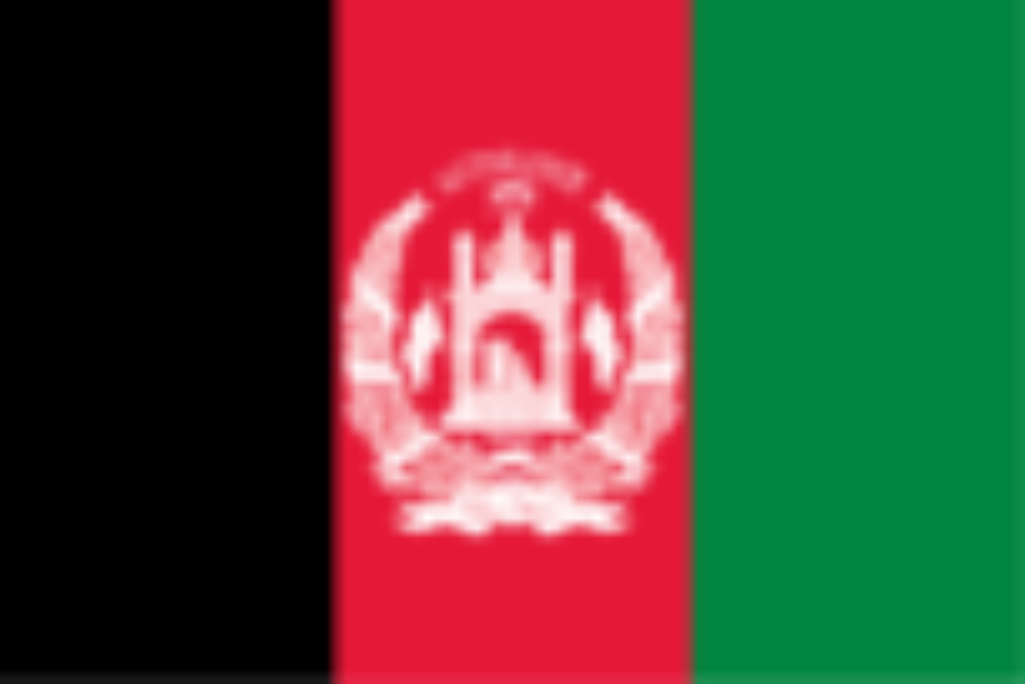

In [89]:
upscaled_afghanistan_reduced_bitmap = imresize(afghanistan_reduced_bitmap, size=max_bounding_box)
visualize_image(upscaled_afghanistan_reduced_bitmap)

## Reduced-size *reconstructed* Afghanistan bitmap, upscaled back to original dimensions

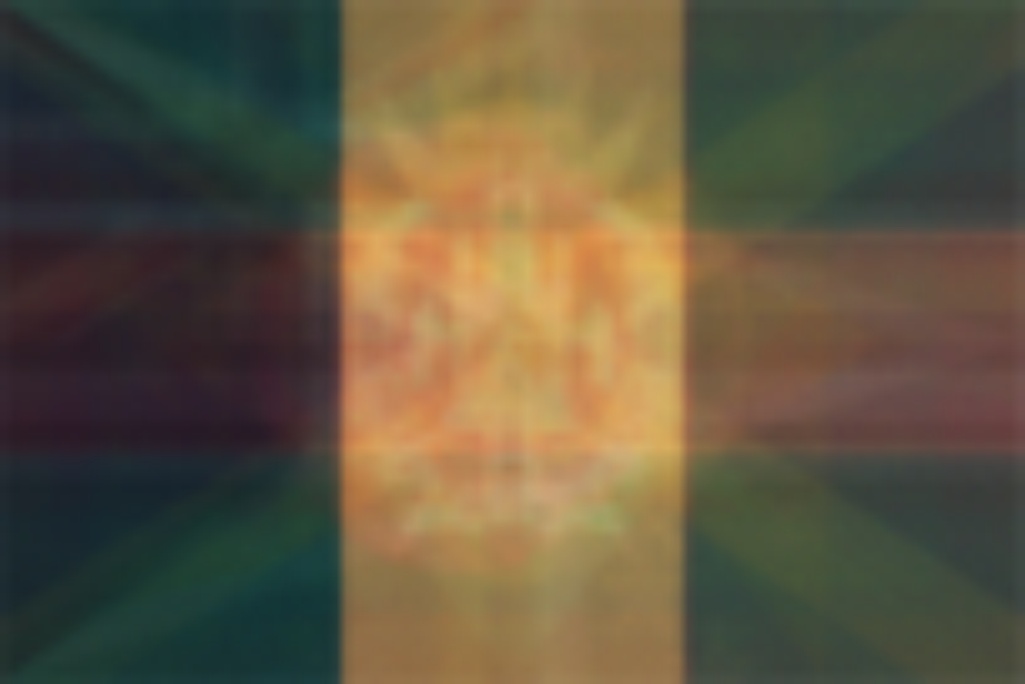

In [90]:
upscaled_reconstructed_afghanistan_reduced_bitmap = imresize(reconstructed_afghanistan_reduced_bitmap, size=max_bounding_box)
visualize_image(upscaled_reconstructed_afghanistan_reduced_bitmap)

# Generate new flags

## Retrieve encodings for each country

In [101]:
encodings = {}
for country, country_input in zip(countries, input_matrix):
    _, encoding = network.predict( country_input.reshape(1, -1) )
    encodings[country] = encoding

## Create our own

In [127]:
composite_prediction = network.generate(
    encodings['morocco'] + \
    encodings['colombia'] + \
    encodings['malaysia']
)

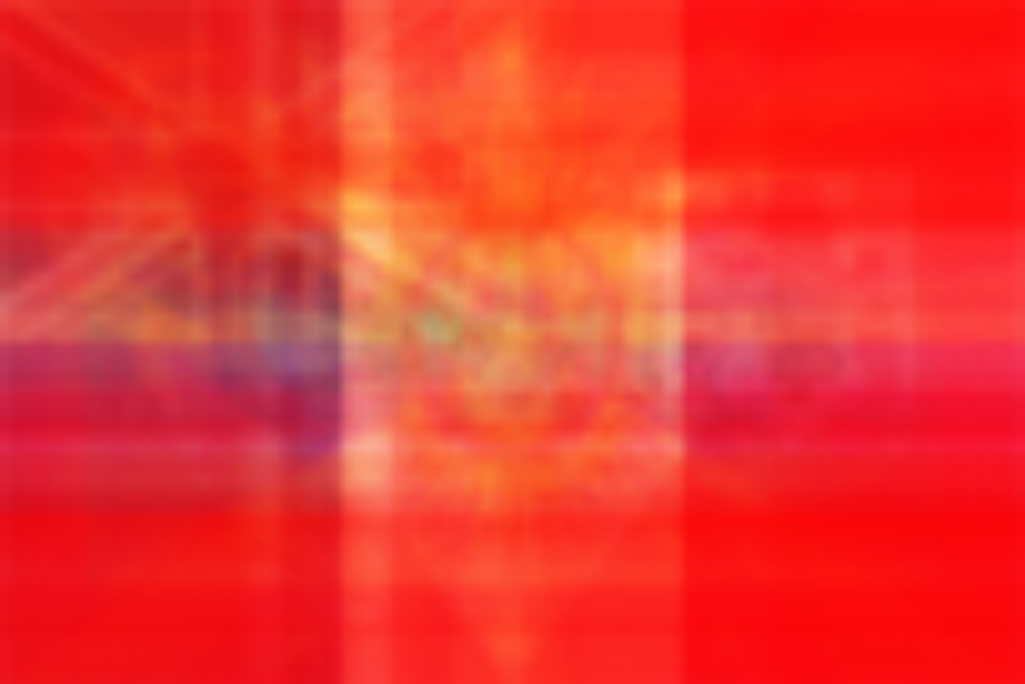

In [128]:
composite_prediction_reshaped = reshape_for_visualization(composite_prediction)
upscaled_composite_prediction_reshaped = imresize(composite_prediction_reshaped, size=max_bounding_box)

visualize_image(upscaled_composite_prediction_reshaped)